<a href="https://colab.research.google.com/github/sokrypton/laxy/blob/main/gremlin_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -qnc https://raw.githubusercontent.com/sokrypton/laxy/main/laxy.py

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import string

from laxy import *

# parse msa

In [3]:
def parse_fasta(filename, a3m=False):
  '''function to parse fasta file'''
  
  if a3m:
    # for a3m files the lowercase letters are removed
    # as these do not align to the query sequence
    rm_lc = str.maketrans(dict.fromkeys(string.ascii_lowercase))
    
  header, sequence = [],[]
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      if a3m: line = line.translate(rm_lc)
      else: line = line.upper()
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  
  return header, sequence
  
def mk_msa(seqs):
  '''one hot encode msa'''
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)  
  a2n = {a:n for n,a in enumerate(alphabet)}
  msa_ori = np.array([[a2n.get(aa, states-1) for aa in seq] for seq in seqs])
  return np.eye(states)[msa_ori]

In [4]:
from scipy.spatial.distance import pdist, squareform
def get_eff(msa, eff_cutoff=0.8):
  if msa.ndim == 3: msa = msa.argmax(-1)    
  # pairwise identity  
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))
  # weight for each sequence
  msa_w = (msa_sm >= eff_cutoff).astype(np.float)
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

# gremlin

In [5]:
class GREMLIN:
  '''GREMLIN implemented in jax'''
  
  def __init__(self, X, W=None, batch_size=None, lam=0.01):
    N,L,A = X.shape
    self.X = jnp.array(X)
    self.W = jnp.array(W) if W is not None else None
    self.batch_size = batch_size

    if batch_size is None:
      self.lam = lam
      self.lr = 0.1 * np.log(N)/L
    else:
      self.key = KEY()
      self.lam = lam * batch_size/N
      self.lr = 0.1 * jnp.log(batch_size)/L

    # setup the model
    def model(params,inputs):
      y_logits, l2_loss = MRF(params)(inputs["x"], l2=True)
      y = jax.nn.softmax(y_logits,-1)
      loss = -(inputs["x"] * jnp.log(y + 1e-8)).sum([1,2])
      if self.W is not None:
        loss = loss * inputs["w"]
      return loss.sum() + self.lam * l2_loss

    params = MRF()(L=L,A=A)

    # initialize bias
    pc = 0.01 * np.log(N)
    b_ini = np.log(np.sum(X,0) + pc)
    b_ini = b_ini - np.mean(b_ini,-1,keepdims=True)
    params["b"] = jnp.array(b_ini)

    # setup optimizer
    self.opt = OPT(model, params, lr=self.lr)

  def get_contacts(self):
    '''get contact map from W matrix'''
    def _apc(x):
      no_diag = (1-jnp.eye(x.shape[0]))
      x = x * no_diag
      a1,a2 = x.sum(0,keepdims=True),x.sum(1,keepdims=True)
      y = x - (a1*a2)/x.sum()
      return y * no_diag
    w = self.opt.get_params()["w"]
    w = (w + w.transpose([2,3,0,1]))/2
    raw = jnp.sqrt(jnp.square(w[:,:20,:,:20]).sum((1,3)))
    return _apc(raw)
    
  def fit(self, steps=100, verbose=True):
    '''train model'''
    
    # define inputs
    inputs = {"x":self.X}
    if self.W is not None: inputs["w"] = self.W

    # subsample if batch_size defined
    if self.batch_size is not None:
      def subsample(self, inputs, key):
        idx = jax.random.randint(key, shape=(self.batch_size,),
                                 minval=0, maxval=inputs["x"].shape[0])
        return {k:inputs[k][idx] for k in inputs.keys()}
      subsample = jax.jit(subsample)

    # fit!
    for k in range(steps):
      if self.batch_size is not None:
        loss = self.opt.train_on_batch(subsample(inputs, self.key.get()))
      else:
        loss = self.opt.train_on_batch(inputs)
      if verbose and (k+1) % (steps//10) == 0:
        print(k+1,loss)

#example

In [6]:
!wget -qnc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [7]:
names, seqs = parse_fasta("4FAZA.fas")
msa = mk_msa(seqs)
msa_weights = get_eff(msa)
print(msa.shape)

(817, 62, 21)


In [8]:
model = GREMLIN(msa, msa_weights)

In [9]:
%%time
model.fit()

10 31093.637
20 28594.408
30 27666.281
40 27281.22
50 27105.768
60 27021.943
70 26976.688
80 26949.621
90 26931.873
100 26919.34
CPU times: user 878 ms, sys: 180 ms, total: 1.06 s
Wall time: 1.14 s


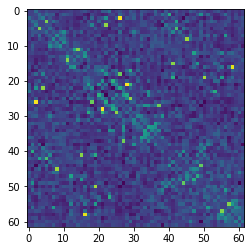

In [10]:
plt.imshow(model.get_contacts())